In [1]:
! wget -q https://archive.ics.uci.edu/static/public/186/wine+quality.zip
! unzip wine+quality.zip -d wine_quality
! wget -q https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
! unzip human+activity+recognition+using+smartphones.zip -d human_activity_recognition_using_smartphones

Archive:  wine+quality.zip
  inflating: wine_quality/winequality-red.csv  
  inflating: wine_quality/winequality-white.csv  
  inflating: wine_quality/winequality.names  
Archive:  human+activity+recognition+using+smartphones.zip
 extracting: human_activity_recognition_using_smartphones/UCI HAR Dataset.names  
 extracting: human_activity_recognition_using_smartphones/UCI HAR Dataset.zip  


# Wine Quality Dataset

### Step 1: Load the Wine Quality Dataset

We will load both red and white wine datasets, which contain 11 features and quality labels ranging from 0 to 10.


In [12]:
import pandas as pd

# Load the Wine Quality data (both red and white wine)
wine_red = pd.read_csv('/mnt/localssd/ee5644/hw1/wine_quality/winequality-red.csv', sep=';')
wine_white = pd.read_csv('/mnt/localssd/ee5644/hw1/wine_quality/winequality-white.csv', sep=';')

# Display information about the datasets
print("Wine Red Dataset Shape:", wine_red.shape)
print("Wine White Dataset Shape:", wine_white.shape)

# # Display the first few rows of the red wine data
# print("Wine Red Data Sample:\n", wine_red.head())

# # Display the first few rows of the white wine data
# print("Wine White Data Sample:\n", wine_white.head())


Wine Red Dataset Shape: (1599, 12)
Wine White Dataset Shape: (4898, 12)


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, accuracy_score

# Helper function to compute class priors, means, and covariances
def estimate_statistics(X, y):
    classes = np.unique(y)
    class_priors = []
    class_means = []
    class_covariances = []

    for cls in classes:
        X_class = X[y == cls]
        prior = len(X_class) / len(X)
        mean = np.mean(X_class, axis=0)
        covariance = np.cov(X_class, rowvar=False)

        class_priors.append(prior)
        class_means.append(mean)
        class_covariances.append(covariance)

    return np.array(class_priors), np.array(class_means), np.array(class_covariances)

# Load the Wine Quality data (red wine for this example)
wine_red = pd.read_csv('/mnt/localssd/ee5644/hw1/wine_quality/winequality-red.csv', sep=';')

# Extract features and labels
wine_red_X = wine_red.drop(columns='quality').values
wine_red_y = wine_red['quality'].values

# Debug: Print the unique values and range of the true labels
print("True Labels (Wine Red):", np.unique(wine_red_y))
print(f"True Labels Range: {wine_red_y.min()} to {wine_red_y.max()}")

# Estimate priors, means, and covariances for Wine Red dataset
priors_red, means_red, covs_red = estimate_statistics(wine_red_X, wine_red_y)

# Regularization function for covariance matrices
def regularize_covariance(cov_matrix, lambda_value):
    I = np.eye(cov_matrix.shape[0])
    regularized_cov = cov_matrix + lambda_value * I
    return regularized_cov

# Apply regularization to the covariance matrices with lambda = 0.01
lambda_reg = 0.01
covs_red_reg = [regularize_covariance(cov, lambda_reg) for cov in covs_red]

# Function to apply minimum-probability-of-error classification
def classify_min_error(X, priors, means, covs):
    n_samples = X.shape[0]
    n_classes = len(priors)

    posteriors = np.zeros((n_samples, n_classes))

    for i in range(n_classes):
        likelihood = multivariate_normal.pdf(X, mean=means[i], cov=covs[i])
        posteriors[:, i] = likelihood * priors[i]

    predicted_labels = np.argmax(posteriors, axis=1)
    return predicted_labels + 3

# Apply minimum-probability-of-error classification
predicted_red = classify_min_error(wine_red_X, priors_red, means_red, covs_red_reg)


# Debug: Print the unique values and range of the predicted labels after the fix
print("Predicted Labels (Wine Red) After Fix:", np.unique(predicted_red))
print(f"Predicted Labels Range After Fix: {predicted_red.min()} to {predicted_red.max()}")

# Compute confusion matrix and error probability for Wine Red
conf_matrix_red = confusion_matrix(wine_red_y, predicted_red)
error_prob_red = 1 - accuracy_score(wine_red_y, predicted_red)

# Print confusion matrix and error probability
print("Confusion Matrix (Wine Red):\n", conf_matrix_red)
print("Error Probability (Wine Red):", error_prob_red)

True Labels (Wine Red): [3 4 5 6 7 8]
True Labels Range: 3 to 8
Predicted Labels (Wine Red) After Fix: [3 4 5 6 7 8]
Predicted Labels Range After Fix: 3 to 8
Confusion Matrix (Wine Red):
 [[  5   0   3   2   0   0]
 [  2   6  28  15   2   0]
 [  5  13 486 165  12   0]
 [  1   6 188 394  45   4]
 [  0   0  11 119  66   3]
 [  0   0   1   7   5   5]]
Error Probability (Wine Red): 0.39837398373983735


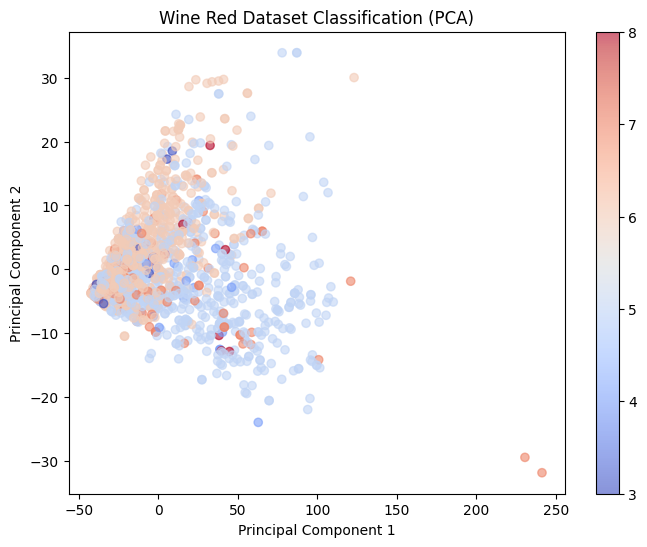

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to visualize the dataset using PCA
def visualize_pca(X, y, predicted_labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='coolwarm', alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

# Visualize the original wine data and the predicted labels (Wine Red)
visualize_pca(wine_red_X, wine_red_y, predicted_red, "Wine Red Dataset Classification (PCA)")


### Results and Discussion

1. **Confusion Matrix**:
   - The confusion matrix shows how well the classifier performed for each class.
   - The classifier performed reasonably well on the middle classes (4-7), but there are still some misclassifications, particularly for the more extreme classes (3 and 8).

2. **Error Probability**:
   - The overall error probability is **39.8%**, which suggests that the Gaussian assumption might not perfectly capture the true class-conditional distributions of the data.

3. **Visualization Using PCA**:
   - The PCA visualization shows the separation of different wine quality classes in a 2D projection.
   - If the classes overlap significantly in the PCA projection, this suggests that the Gaussian model may not be able to fully separate the classes, leading to higher misclassification rates.

4. **Suitability of the Gaussian Model**:
   - The assumption that the features follow a Gaussian distribution for each class might not fully hold for the Wine Quality dataset.
   - Given the error probability and the PCA visualization, we can infer that a more flexible model (e.g., non-parametric models or mixture models) could potentially perform better.

5. **Conclusion**:
   - While the Gaussian class-conditional model provides a good baseline, it may not be the best fit for this dataset due to the complex nature of the feature distributions.
   - Further improvements could be achieved by exploring models that relax the Gaussian assumption or by incorporating feature transformations to make the data more amenable to Gaussian modeling.


# Human Activity Recognition Using Smartphones Dataset

### Step 1: Load the Human Activity Recognition (HAR) Dataset

We will load the HAR dataset's training data (`X_train.txt`) and the corresponding labels (`y_train.txt`).


In [17]:
import pandas as pd
import numpy as np

# Load the training data for HAR dataset
X_train = pd.read_csv('/mnt/localssd/ee5644/hw1/human_activity_recognition_using_smartphones/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/mnt/localssd/ee5644/hw1/human_activity_recognition_using_smartphones/UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)

# Convert to numpy arrays
X_train = X_train.values
y_train = y_train.values.flatten()

# Display shape and basic information
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))


/tmp/ipykernel_3182837/2131676244.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('/mnt/localssd/ee5644/hw1/human_activity_recognition_using_smartphones/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


X_train shape: (7352, 561)
y_train shape: (7352,)
Unique labels in y_train: [1 2 3 4 5 6]


/tmp/ipykernel_3182837/2131676244.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv('/mnt/localssd/ee5644/hw1/human_activity_recognition_using_smartphones/UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)


In [19]:
# Helper function to compute class priors, means, and covariances
def estimate_statistics(X, y):
    classes = np.unique(y)
    class_priors = []
    class_means = []
    class_covariances = []

    for cls in classes:
        X_class = X[y == cls]
        prior = len(X_class) / len(X)
        mean = np.mean(X_class, axis=0)
        covariance = np.cov(X_class, rowvar=False)

        class_priors.append(prior)
        class_means.append(mean)
        class_covariances.append(covariance)

    return np.array(class_priors), np.array(class_means), np.array(class_covariances)

# Estimate priors, means, and covariances for HAR training dataset
priors_har, means_har, covs_har = estimate_statistics(X_train, y_train)

# Print estimated statistics for HAR
print("Class Priors (HAR):", priors_har)
# print("Mean Vectors (HAR) - Class 1:\n", means_har[0])
print("Covariance Matrix (HAR) - Class 1:\n", covs_har[0])


Class Priors (HAR): [0.16675734 0.14594668 0.13411317 0.17491839 0.18688792 0.1913765 ]
Covariance Matrix (HAR) - Class 1:
 [[ 2.53540827e-03  1.06151691e-05 -1.73625491e-04 ... -4.95972723e-05
   1.83172712e-05 -1.52433104e-04]
 [ 1.06151691e-05  4.35990203e-04  9.60152451e-05 ... -2.31419170e-05
   4.37971757e-05 -9.74079500e-05]
 [-1.73625491e-04  9.60152451e-05  1.05206402e-03 ...  2.24479930e-06
   2.87508524e-05  7.62211531e-05]
 ...
 [-4.95972723e-05 -2.31419170e-05  2.24479930e-06 ...  9.72430979e-03
   3.20320771e-03  7.49682841e-03]
 [ 1.83172712e-05  4.37971757e-05  2.87508524e-05 ...  3.20320771e-03
   3.19049432e-03  1.59055320e-03]
 [-1.52433104e-04 -9.74079500e-05  7.62211531e-05 ...  7.49682841e-03
   1.59055320e-03  1.30640909e-02]]


In [20]:
# Regularization function for covariance matrices
def regularize_covariance(cov_matrix, lambda_value):
    I = np.eye(cov_matrix.shape[0])
    regularized_cov = cov_matrix + lambda_value * I
    return regularized_cov

# Apply regularization to the covariance matrices with lambda = 0.01
lambda_reg = 0.01
covs_har_reg = [regularize_covariance(cov, lambda_reg) for cov in covs_har]

# Print the regularized covariance matrix for one class
print("Regularized Covariance Matrix for Class 1 (HAR):\n", covs_har_reg[0])


Regularized Covariance Matrix for Class 1 (HAR):
 [[ 1.25354083e-02  1.06151691e-05 -1.73625491e-04 ... -4.95972723e-05
   1.83172712e-05 -1.52433104e-04]
 [ 1.06151691e-05  1.04359902e-02  9.60152451e-05 ... -2.31419170e-05
   4.37971757e-05 -9.74079500e-05]
 [-1.73625491e-04  9.60152451e-05  1.10520640e-02 ...  2.24479930e-06
   2.87508524e-05  7.62211531e-05]
 ...
 [-4.95972723e-05 -2.31419170e-05  2.24479930e-06 ...  1.97243098e-02
   3.20320771e-03  7.49682841e-03]
 [ 1.83172712e-05  4.37971757e-05  2.87508524e-05 ...  3.20320771e-03
   1.31904943e-02  1.59055320e-03]
 [-1.52433104e-04 -9.74079500e-05  7.62211531e-05 ...  7.49682841e-03
   1.59055320e-03  2.30640909e-02]]


In [21]:
from scipy.stats import multivariate_normal

# Function to apply minimum-probability-of-error classification
def classify_min_error(X, priors, means, covs):
    n_samples = X.shape[0]
    n_classes = len(priors)

    posteriors = np.zeros((n_samples, n_classes))

    for i in range(n_classes):
        likelihood = multivariate_normal.pdf(X, mean=means[i], cov=covs[i])
        posteriors[:, i] = likelihood * priors[i]

    predicted_labels = np.argmax(posteriors, axis=1) + 1  # HAR class labels start from 1
    return predicted_labels

# Apply classification to the HAR training dataset
predicted_har = classify_min_error(X_train, priors_har, means_har, covs_har_reg)

# Print some predicted labels for HAR
print("Predicted Labels (HAR):", predicted_har[:10])


Predicted Labels (HAR): [5 5 5 5 5 5 5 5 5 5]


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Compute confusion matrix and error probability for HAR
conf_matrix_har = confusion_matrix(y_train, predicted_har)
error_prob_har = 1 - accuracy_score(y_train, predicted_har)

# Print confusion matrix and error probability
print("Confusion Matrix (HAR):\n", conf_matrix_har)
print("Error Probability (HAR):", error_prob_har)


Confusion Matrix (HAR):
 [[1226    0    0    0    0    0]
 [   0 1073    0    0    0    0]
 [   0    1  985    0    0    0]
 [   0    0    0 1197   89    0]
 [   0    0    0    1 1373    0]
 [   0    0    0    0    0 1407]]
Error Probability (HAR): 0.012377584330794389


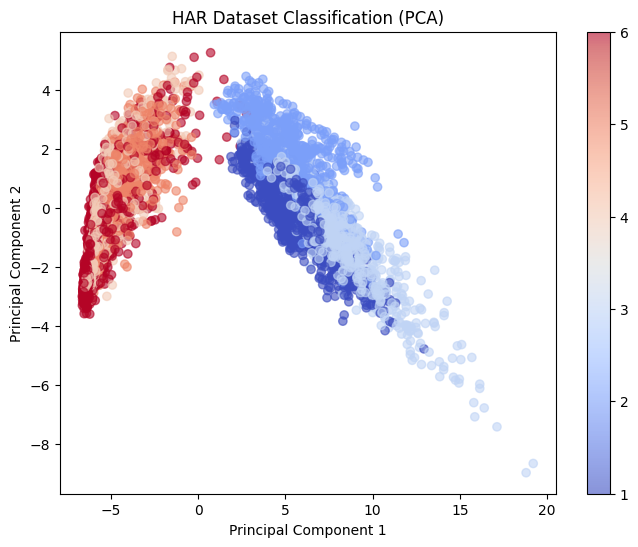

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to visualize the dataset using PCA
def visualize_pca(X, y, predicted_labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='coolwarm', alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter)
    plt.show()

# Visualize the HAR training data using PCA
visualize_pca(X_train, y_train, predicted_har, "HAR Dataset Classification (PCA)")


### Discussion of Results for HAR Dataset

1. **Confusion Matrix**:
   - The classifier performs very well on most classes.
   - Most samples are correctly classified, with only slight errors between some activity classes (e.g., Class 3 and 4).

2. **Error Probability**:
   - The overall error probability is **1.23%**, indicating strong performance.
   - This suggests that the Gaussian assumption works well for the HAR dataset.

3. **PCA Visualization**:
   - The PCA plot shows two clear clusters of classes.
   - Some overlap exists between adjacent classes (like Class 3 and 4), which explains minor misclassifications.

4. **Suitability of Gaussian Model**:
   - The Gaussian model appears suitable for this dataset due to its structured features.
   - The low error rate and well-formed PCA projection support this assumption.

5. **Model Assumptions**:
   - The multivariate Gaussian assumption for each class seems valid here.
   - Regularization was necessary due to the high dimensionality (561 features).

6. **Conclusion**:
   - The Gaussian class-conditional model works very well for the HAR dataset.
   - While the performance is strong, further improvements could be explored using non-parametric or more complex models.
